# Train U - Net Model
## Imports

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import clear_output

from config import *

AUTOTUNE = tf.data.experimental.AUTOTUNE
one_hot_encoding = False
palette = None
channels = [3,1]

## Data load functions

In [15]:
def normalize(input_image, input_mask):
    # Normalize the pixel range values between [0:1]
    img = tf.cast(input_image, dtype=tf.float32) / 255.0
    #mask = tf.image.resize(input_mask, (128,128), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = (tf.cast(input_mask, dtype=tf.float32) / 255.0) #* 2.0
    mask = tf.cast(mask, tf.uint8)
    #mask -= 1
    #mask *= -1
    return img, mask

def _one_hot_encode(image, mask):
    """
    Converts mask to a one-hot encoding specified by the semantic map.
    """
    one_hot_map = []
    for colour in palette:
        class_map = tf.reduce_all(tf.equal(mask, colour), axis=-1)
        one_hot_map.append(class_map)
    one_hot_map = tf.stack(one_hot_map, axis=-1)
    one_hot_map = tf.cast(one_hot_map, tf.float32)
    
    return image, one_hot_map

def _parse_data(image_paths, mask_paths):
    """
    Reads image and mask files depending on
    specified exxtension.
    """
    image_content = tf.io.read_file(image_paths)
    mask_content = tf.io.read_file(mask_paths)

    images = tf.image.decode_png(image_content, channels=channels[0])
    masks = tf.image.decode_png(mask_content, channels=channels[1])

    return images, masks

@tf.function
def _map_function(images_path, masks_path):
    image, mask = _parse_data(images_path, masks_path)
    image, mask = normalize(image, mask)
    '''
    def _map_func(image_f, mask_f):
        if one_hot_encoding:
            if palette is None:
                raise ValueError('No Palette for one-hot encoding specified in the data loader! \
                                    please specify one when initializing the loader.')
            image_f, mask_f = _one_hot_encode(image_f, mask_f)

        return image_f, mask_f
    '''
    return image, mask

def batch_data(batch_size, images, masks):
    data = tf.data.Dataset.from_tensor_slices((images, masks))
    data = data.map(_map_function, num_parallel_calls=AUTOTUNE)
    data = data.batch(batch_size)
    return data

## Read data and normalize

In [16]:
AUGUMENTED_IMAGES_DIR_PATH = IMAGES_PATH + "unet_phase_2/"
AUGUMENTED_MASKS_DIR_PATH = IMAGES_PATH + "unet_masks_2/"
BATCH_SIZE = 8
images = sorted([os.path.join(AUGUMENTED_IMAGES_DIR_PATH, x) for x in os.listdir(AUGUMENTED_IMAGES_DIR_PATH) if x.endswith('.png')])
masks = sorted([os.path.join(AUGUMENTED_MASKS_DIR_PATH, x) for x in os.listdir(AUGUMENTED_MASKS_DIR_PATH) if x.endswith('.png')])
len_images = len(images)
curr_image_num = 1

data = batch_data(BATCH_SIZE, images, masks)

#img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)
#images, labels = next(img_gen.flow_from_directory(flowers))

#print(data)
#for image, mask in data:
    #print(image)
    #print(mask)
    #break

## Split data

In [18]:
print(len(data))
train_data = data.take(1500)
test_val_data = data.skip(1500)
val_data = test_val_data.take(300)
test_data_v = test_val_data.skip(300)
print(len(train_data))
print(len(val_data))
print(len(test_data_v))

1957
1500
300
157


## U - Net Model

In [5]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

def unet_model():
    # inputs
   inputs = layers.Input(shape=(128,128,3)) #256,256
   # encoder: contracting path - downsample
   # 0 - downsample
   #f0, p0 = downsample_block(inputs, 32)
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64) #p0
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # 10 - upsample
   #u10 = upsample_block(u9, f0, 32)
   # outputs
   outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9) #u10
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

## Define model

In [6]:
unet_model = unet_model()
#unet_model.summary()
unet_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

## Display help functions

In [7]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

## Preview images and masks

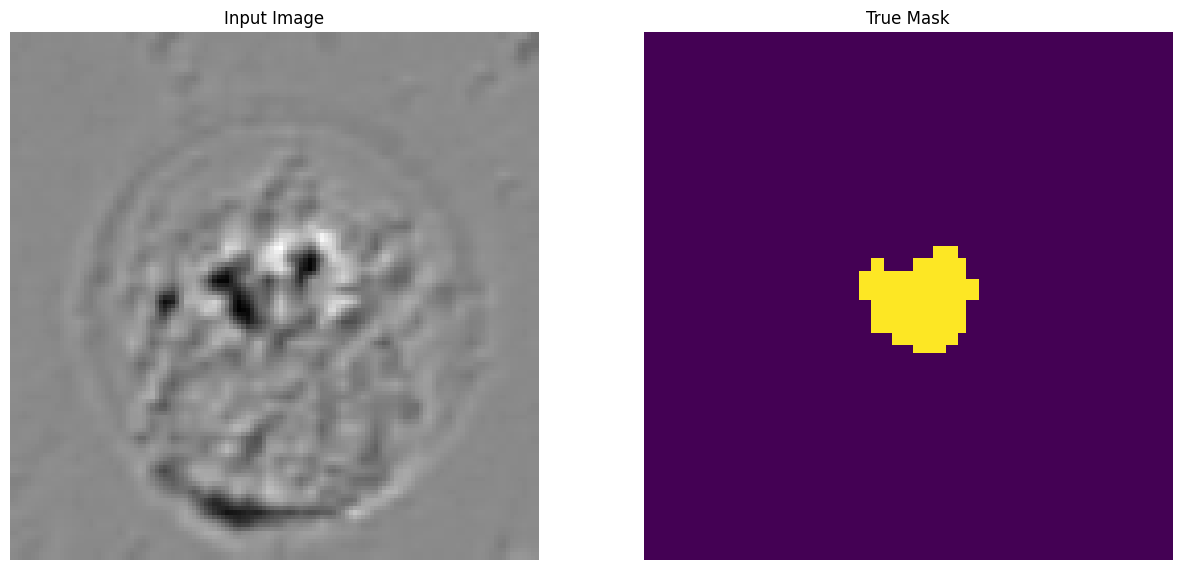

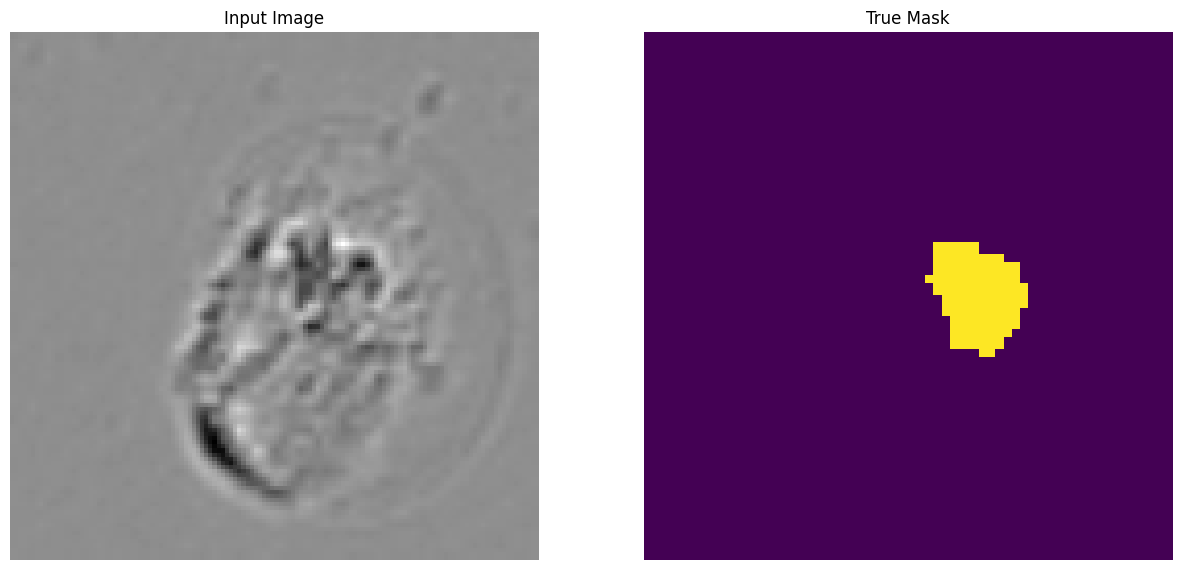

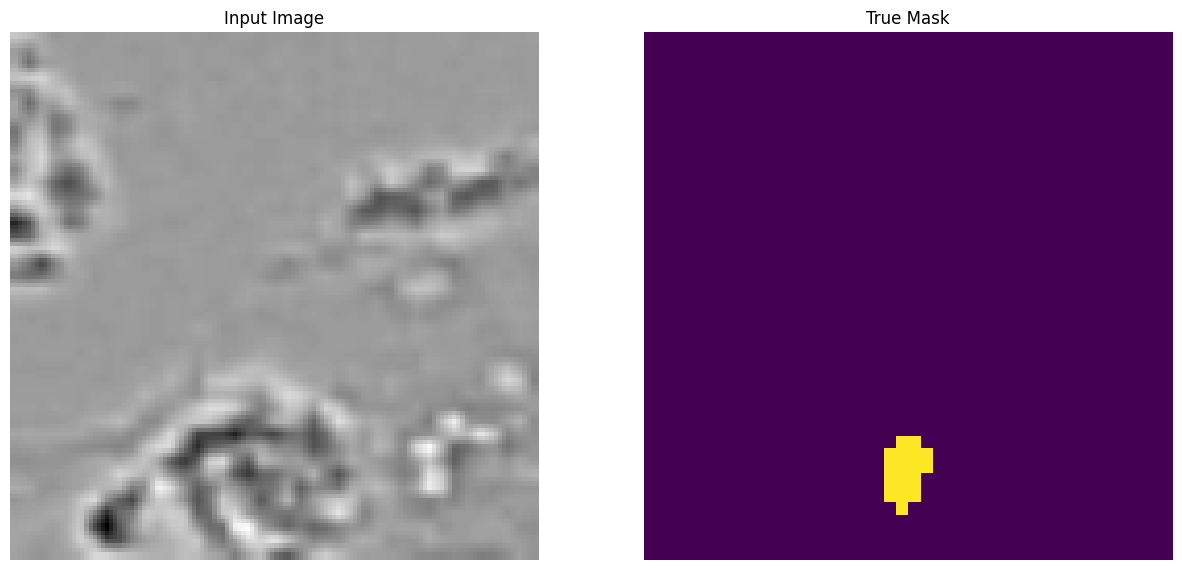

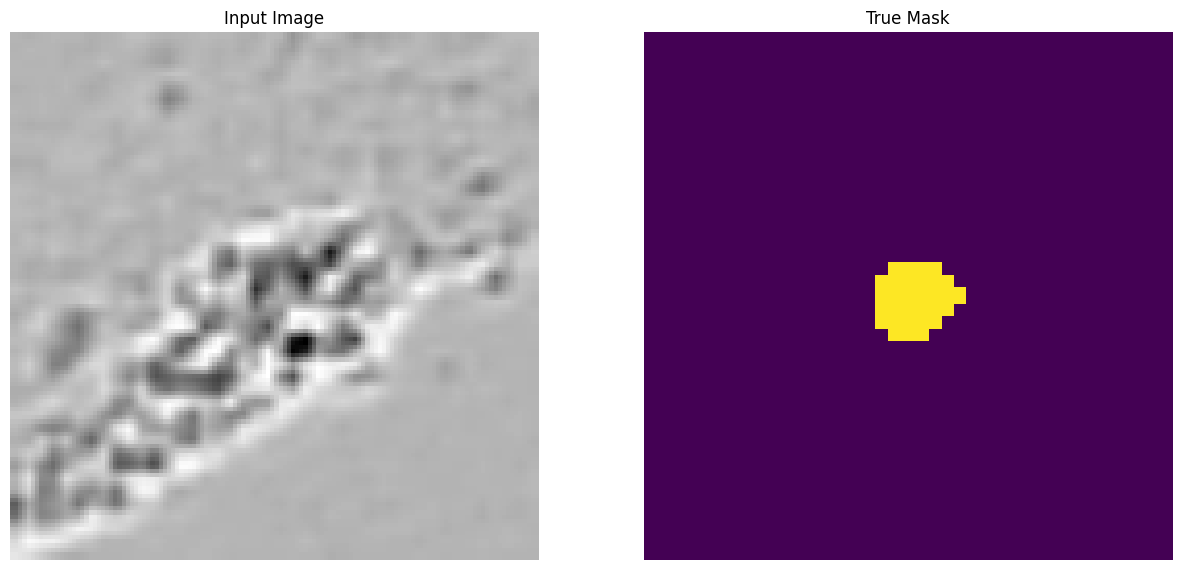

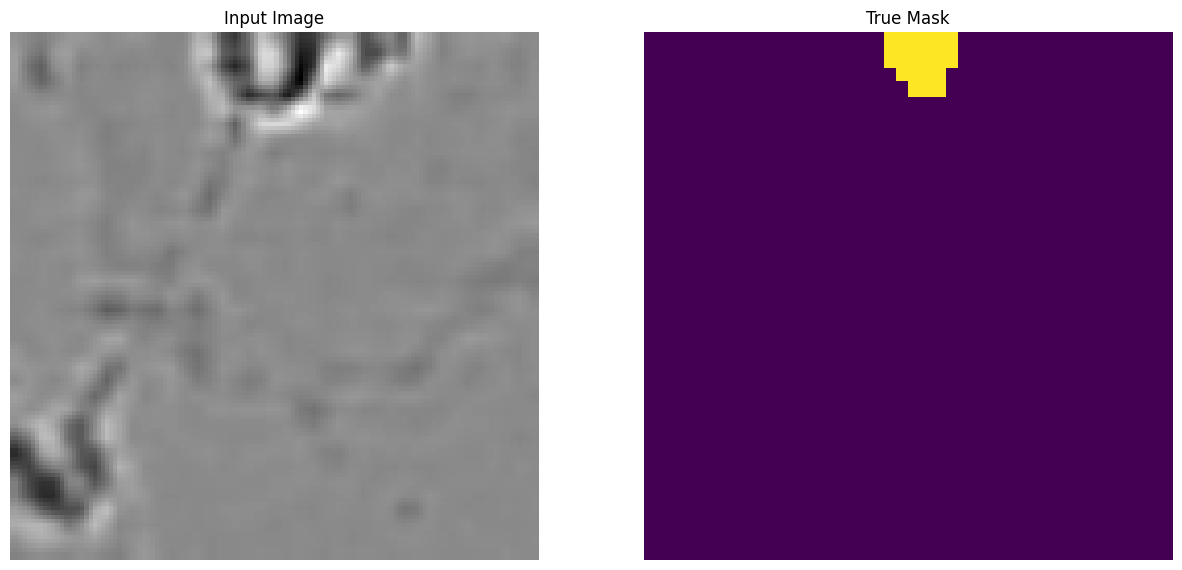

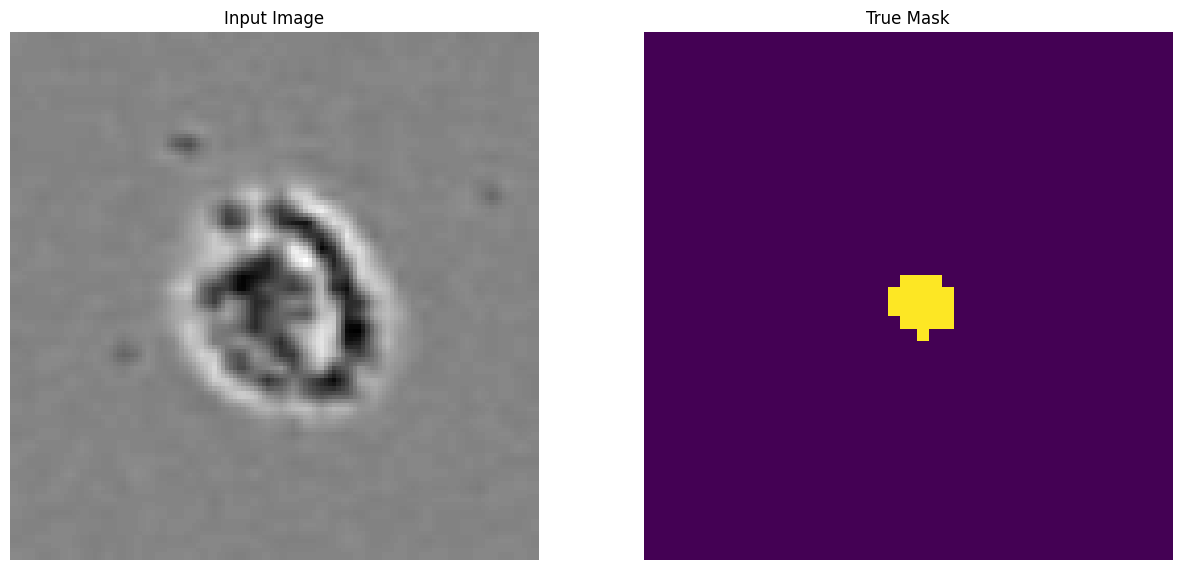

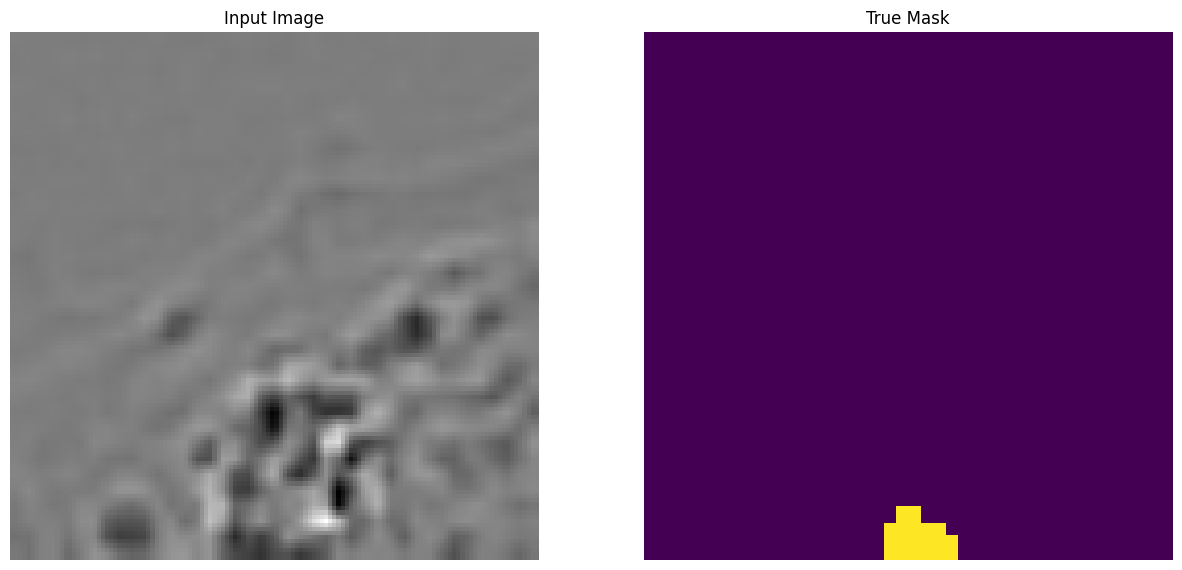

In [8]:
for images, masks in train_data.take(7):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Train help functions

In [9]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  #print(pred_mask)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])
    
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 270ms/step


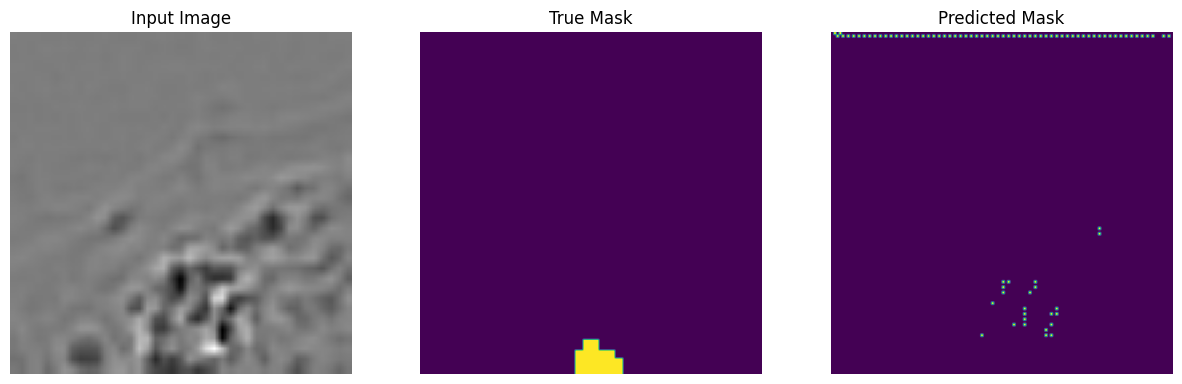

In [10]:
show_predictions()

## Train

In [11]:
NUM_EPOCHS = 15 #10
STEPS_PER_EPOCH = 30 #23
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 10 #// VAL_SUBSPLITS
model_history = unet_model.fit(train_data,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=val_data)


Epoch 1/15


30/30 [==============================] - 81s 3s/step - loss: 0.2028 - accuracy: 0.9799 - val_loss: 0.0502 - val_accuracy: 0.9916
Epoch 2/15
30/30 [==============================] - 80s 3s/step - loss: 0.0871 - accuracy: 0.9840 - val_loss: 0.0485 - val_accuracy: 0.9916
Epoch 3/15
30/30 [==============================] - 80s 3s/step - loss: 0.0980 - accuracy: 0.9843 - val_loss: 0.0482 - val_accuracy: 0.9916
Epoch 4/15
30/30 [==============================] - 80s 3s/step - loss: 0.1025 - accuracy: 0.9801 - val_loss: 0.0682 - val_accuracy: 0.9916
Epoch 5/15
30/30 [==============================] - 80s 3s/step - loss: 0.0629 - accuracy: 0.9884 - val_loss: 0.0493 - val_accuracy: 0.9916
Epoch 6/15
30/30 [==============================] - 80s 3s/step - loss: 0.0962 - accuracy: 0.9819 - val_loss: 0.0588 - val_accuracy: 0.9916
Epoch 7/15
30/30 [==============================] - 81s 3s/step - loss: 0.0797 - accuracy: 0.9850 - val_loss: 0.0482 - val_accuracy: 0.9916
Epoch 8/15
30/30 [=============

## Training history

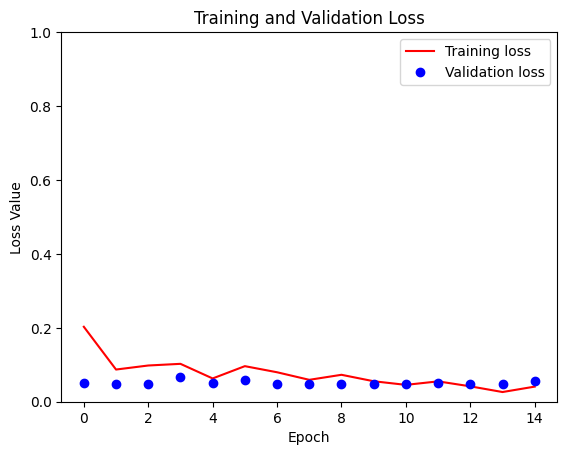

In [12]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Test model

1/1 [==============================] - 1s 705ms/step


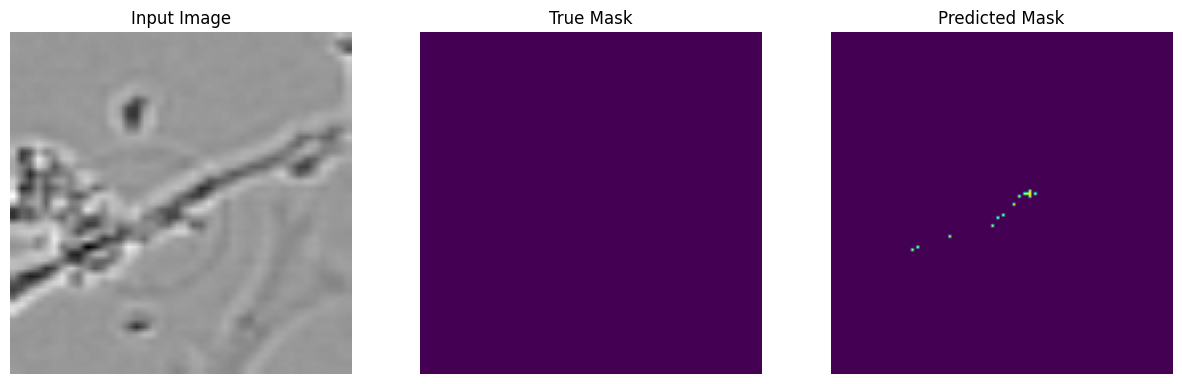

1/1 [==============================] - 1s 762ms/step


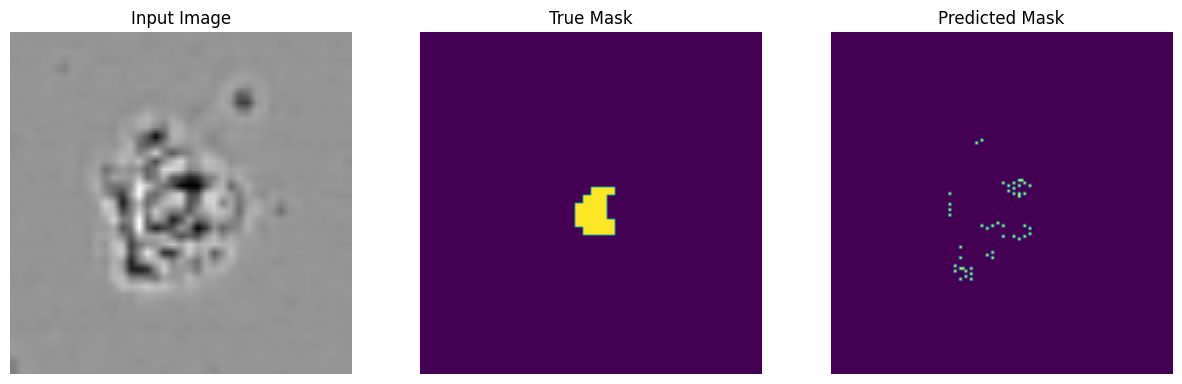

1/1 [==============================] - 1s 763ms/step


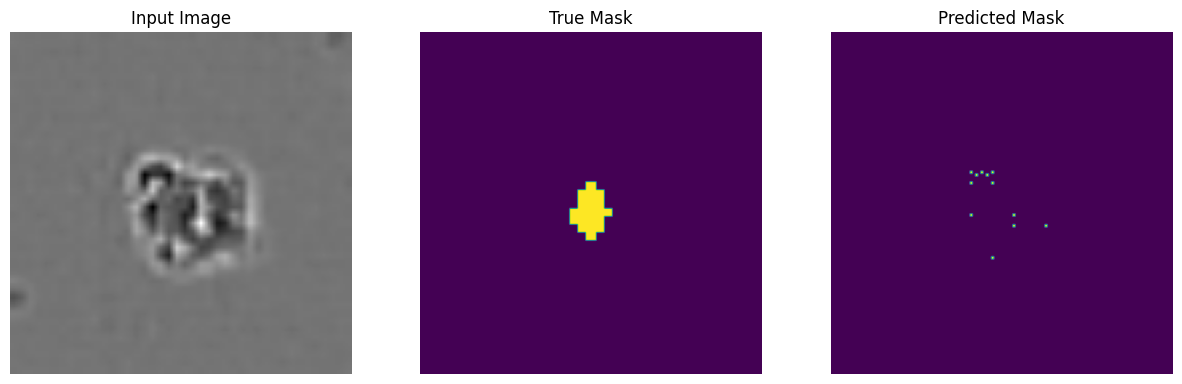

In [13]:
show_predictions(test_data_v, 3)